In [1]:
from dpks.quant_matrix import QuantMatrix
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration, HDBSCAN

import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
design_matrix = pd.read_csv(
    "../tests/input_files/design_sepsis.tsv",
    #"/home/aaron/projects/dpks/notebooks/ml_api/covid_design_matrix.tsv",
    sep="\t"
)

In [3]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)
design_matrix

,sample,group
0,TM_P1911_190,2
1,TM_P1912_030,2
2,TM_P1912_032,2
3,TM_P1912_033,2
4,TM_P1912_034,2
...,...,...
192,TM_M2012_138,1
193,TM_M2012_046,1
194,TM_M2012_129,1
195,TM_M2012_128,1


In [4]:
design_matrix['group'].value_counts()

group
2    123
1     74
Name: count, dtype: int64

In [5]:
qm = (
    
    QuantMatrix(
        quantification_file="../tests/input_files/data_sepsis.tsv",
        design_matrix_file=design_matrix
    )
    .filter()
    .normalize(method="mean", use_rt_sliding_window_filter=True, rt_unit="second", stride=5, minimum_data_points=200)
    .quantify(method="top_n", top_n=5, summarization_method="mean").impute(method="neighborhood")
    .impute(method="neighborhood")
)

/home/aaron/projects/dpks/DPKS/dpks/quantification.py:94: RuntimeWarning: Mean of empty slice
  quantification: np.ndarray = np.nanmean(


In [6]:
qm = qm.compare(
    method="linregress",
    min_samples_per_group=10,
    comparisons=[(2, 1)]
)

In [7]:
X, y = qm.to_ml()

In [8]:
background = qm.append(method="shuffle")

x_background, y_background = QuantMatrix(
    quantification_file=background.to_df()[background.to_df()['Decoy'] == 1].copy(),
    design_matrix_file=design_matrix
).to_ml()

In [9]:
from dpks.cluster import FeatureClustering

clusterer = FeatureClustering(q_value=0.01)

cluster_ids = clusterer.fit_predict(X, x_background)

<Axes: xlabel='distance', ylabel='Count'>

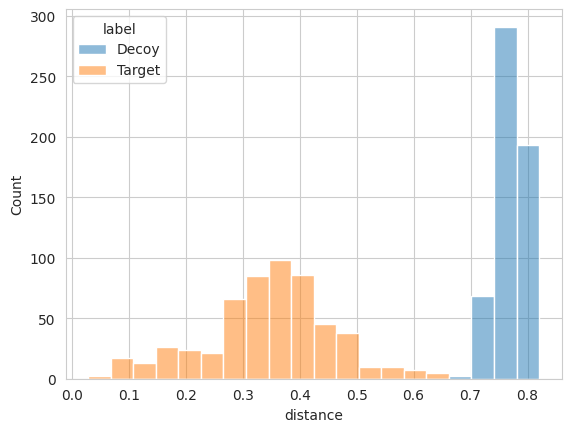

In [10]:
sns.histplot(clusterer.distance_df, x="distance", hue="label", bins=20)

In [11]:
qm.row_annotations['FeatureCluster'] = cluster_ids

In [12]:
qm.row_annotations.sort_values("FeatureCluster")

,Protein,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,FeatureCluster
8,P02787,0.114378,29.080894,29.235061,0.498493,0.448078,-0.154166,3.112043e-02,123,74,2.483154e-02,1.604996,1
39,Q04756,0.392701,19.254499,19.749946,0.687477,0.691365,-0.495446,2.371981e-06,123,74,5.847756e-06,5.233011,1
40,P02768,0.024260,32.911592,32.883534,0.230820,0.241586,0.028058,4.202495e-01,123,74,2.221701e-01,0.653314,1
344,P02786,0.274371,18.213893,18.648340,1.087874,0.857236,-0.434448,3.957148e-03,123,74,4.192893e-03,2.377486,1
9,P00738,0.069402,30.383598,30.264077,1.583586,1.104578,0.119521,5.705962e-01,123,74,2.847264e-01,0.545572,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,P61769,1.076449,22.823686,21.643795,0.733103,0.974937,1.179891,4.413086e-18,123,74,1.373573e-16,15.862148,139
524,P04206,0.483930,20.836447,20.325710,0.592031,0.552182,0.510737,1.036226e-08,123,74,4.448624e-08,7.351774,140
204,P41222,0.589965,20.108852,19.354449,0.756752,0.944021,0.754403,4.742012e-09,123,74,2.186595e-08,7.660232,140
423,P36222,0.769862,19.807596,18.697789,1.363901,0.734480,1.109807,9.818212e-10,123,74,4.989255e-09,8.301964,140


In [13]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

dist_linkage = hierarchy.linkage(
    squareform(clusterer.target_distance_matrix), 
    method="ward"
)

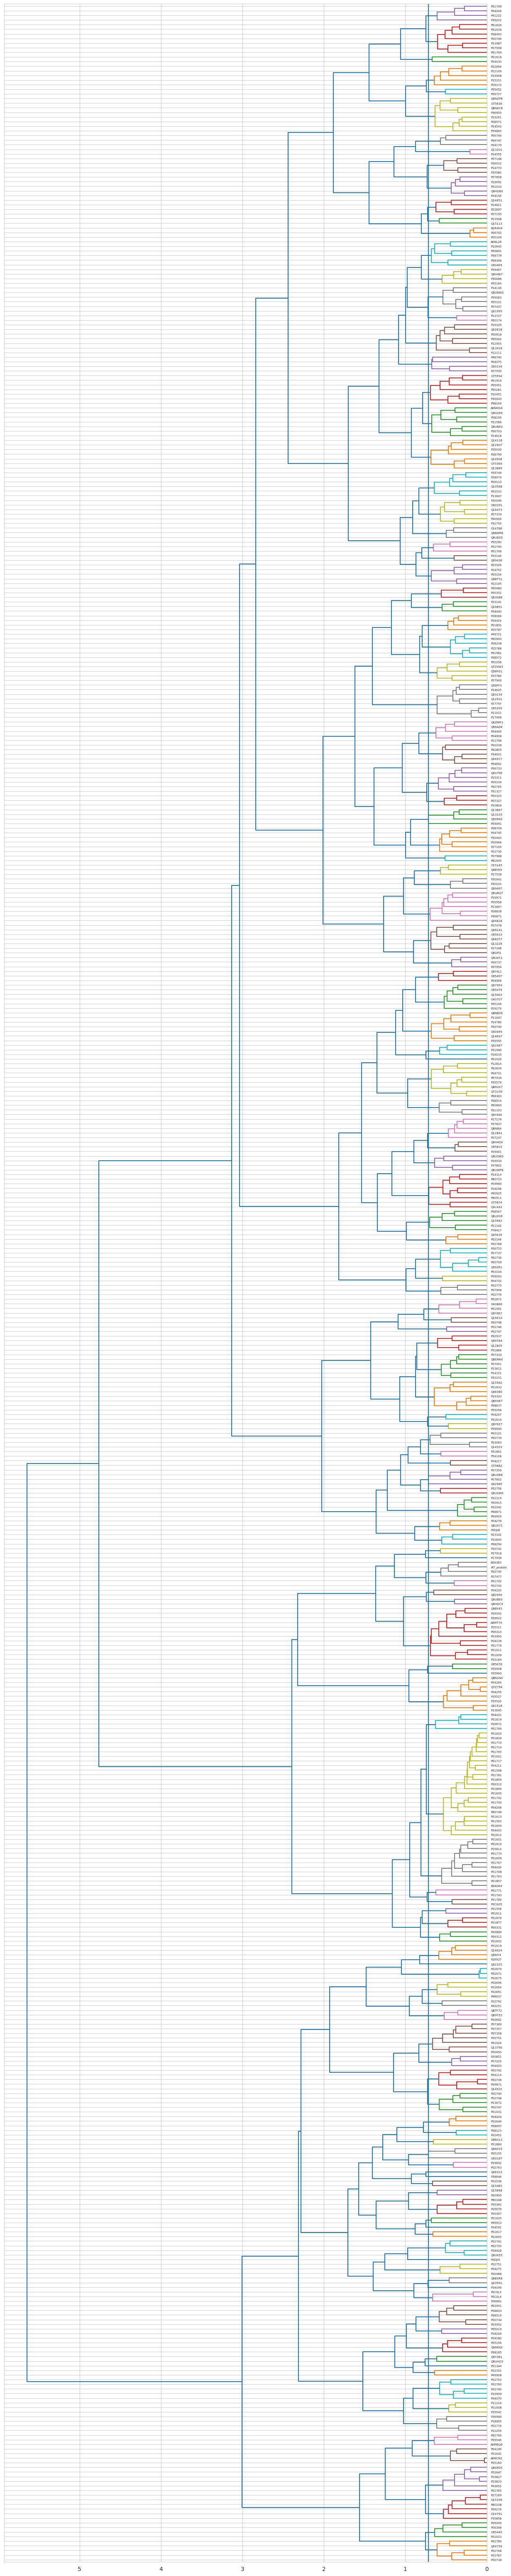

In [23]:
import matplotlib.pyplot as plt

plt.figure()

dn = hierarchy.dendrogram(dist_linkage, 
                          orientation="left", 
                          color_threshold=clusterer.distance_cutoff,
                          labels=X.columns.values)

plt.gca().axvline(x=clusterer.distance_cutoff)

plt.gcf().set_size_inches(15, 80)

In [16]:
np.unique(cluster_ids).shape

(140,)

In [18]:
qm.row_annotations.sort_values("FeatureCluster")

,Protein,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,CorrectedPValue2-1,-Log10CorrectedPValue2-1,FeatureCluster
8,P02787,0.114378,29.080894,29.235061,0.498493,0.448078,-0.154166,3.112043e-02,123,74,2.483154e-02,1.604996,1
39,Q04756,0.392701,19.254499,19.749946,0.687477,0.691365,-0.495446,2.371981e-06,123,74,5.847756e-06,5.233011,1
40,P02768,0.024260,32.911592,32.883534,0.230820,0.241586,0.028058,4.202495e-01,123,74,2.221701e-01,0.653314,1
344,P02786,0.274371,18.213893,18.648340,1.087874,0.857236,-0.434448,3.957148e-03,123,74,4.192893e-03,2.377486,1
9,P00738,0.069402,30.383598,30.264077,1.583586,1.104578,0.119521,5.705962e-01,123,74,2.847264e-01,0.545572,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,P61769,1.076449,22.823686,21.643795,0.733103,0.974937,1.179891,4.413086e-18,123,74,1.373573e-16,15.862148,139
524,P04206,0.483930,20.836447,20.325710,0.592031,0.552182,0.510737,1.036226e-08,123,74,4.448624e-08,7.351774,140
204,P41222,0.589965,20.108852,19.354449,0.756752,0.944021,0.754403,4.742012e-09,123,74,2.186595e-08,7.660232,140
423,P36222,0.769862,19.807596,18.697789,1.363901,0.734480,1.109807,9.818212e-10,123,74,4.989255e-09,8.301964,140


In [19]:
qm.row_annotations['FeatureCluster'].min()

1